In [169]:
import RxInferClientOpenAPI
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from visualisation import *

In [170]:
class RxInfer:
	def __init__(self, token: str = None):
		self.client = RxInferClientOpenAPI.ApiClient()
		if token:
			self.token = token
		else:
			self.token = RxInferClientOpenAPI.AuthenticationApi(self.client).generate_token().token
			print(f"A new token has been generated: {self.token}")
		self.client.default_headers['Authorization'] = f"Bearer {self.token}"
	
	def create_model(self, model_name: str, description: str = None):
		self.model_id = RxInferClientOpenAPI.ModelsApi(self.client).create_model({
			"model": model_name,
			"description": description}).model_id
		print(f"Model {model_name} has been created with id {self.model_id}")
		return self.model_id
	
	def infer(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		if (data is not None)and (data.get("t") is not None)and (timestamp is None):
			timestamp = data.get("t")[0]
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_inference(
			model_id=selected_model_id,
			infer_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	
	def plan(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_planning(
			model_id=selected_model_id,
			planning_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	
	def act(self, model_id: str = None, data: dict = None, timestamp: str = None, episode_name: str = "default"):
		selected_model_id = model_id if model_id else self.model_id
		response = RxInferClientOpenAPI.ModelsApi(self.client).run_action(
			model_id=selected_model_id,
			act_request={
				"data": data,
				"timestamp": timestamp,
				"episode_name": episode_name
			})
		return response
	

In [171]:
def move_drone(client=RxInfer(), target=[3, 2, 1, 0, 0, 0, 1, 0, 0, 0], tolerance=0.05, max_steps=100):
    client.create_model("Drone-MPC")
    control = [0.0, 0.0, 0.0, 0.0]  # Initial control input
    target_reached = False
    step_count = 0
    
    # Keep track of history
    history = {
        "plans": [],
        "actions": [],
        "inferences": [],
        "controls": [],
        "positions": []
    }
    
    # Initialize state for first iteration
    current_state = None
    
    while not target_reached and step_count < max_steps:
        # Plan step with current state if available
        plan_data = {
            "t": [0.0],
            "target": target,
            "control": control
        }
        
        # If we have a current state from previous inference, use it
        if current_state is not None:
            plan_data.update(current_state)
        
        plan = client.plan(data=plan_data)
        history["plans"].append(plan)
        
        # Extract the applied control from planning results
        applied_control = plan.results["applied_control"]
        history["controls"].append(applied_control)
        
        # Execute action with the applied control
        action_response = client.act(
            data={
                "t": [0.0],
                "control": applied_control
            }
        )
        history["actions"].append(action_response)
        
        # Get measurement from action response for inference
        measurement = action_response.results["measurement"]
        
        # Run inference with the measurement
        inference_response = client.infer(
            data={
                "measurement": measurement,
                "t": [0.0]
            }
        )
        history["inferences"].append(inference_response)
        
        # Update current state for next iteration
        current_state = {
            "state_mean": inference_response.results["state_mean"],
            "state_covariance": inference_response.results["state_covariance"]
        }
        
        # Extract position from state_mean (first 3 elements)
        position_mean = inference_response.results["state_mean"][:3]
        history["positions"].append(position_mean)
        
        # Check if target position is reached
        distance = np.linalg.norm(np.array(target[:3]) - np.array(position_mean))
        
        print(f"Step {step_count}: Position = {position_mean}, Distance to target = {distance:.4f}")
        
        target_reached = distance < tolerance
        
        # Use the applied control for the next iteration
        control = applied_control
        step_count += 1
    
    if target_reached:
        print(f"Target reached in {step_count} steps!")
    else:
        print(f"Maximum steps ({max_steps}) reached without converging to target.")
    
    return control, history

# Don't automatically run the function
# move_drone()

A new token has been generated: d381ccb0-285b-4e60-bd8e-04778cabca19


In [172]:
control, history = move_drone();

Model Drone-MPC has been created with id 4b95f833-7bc6-4487-9604-3c34588785d9
Step 0: Position = [-0.032176935540644665, -0.02526167633407677, -0.12511993543057767], Distance to target = 3.8160
Step 1: Position = [-0.1072153557899861, -0.054907651120660456, -0.07896941396223027], Distance to target = 3.8784
Step 2: Position = [-0.10113211018642927, -0.08522796373919685, -0.10906644770478219], Distance to target = 3.8981
Step 3: Position = [-0.11507305662463088, -0.020150387887117982, -0.15516127463670543], Distance to target = 3.8883
Step 4: Position = [-0.08340420243675355, -0.010731311926895803, -0.231325519066545], Distance to target = 3.8816
Step 5: Position = [-0.05229893844331027, 0.0020089973229352096, -0.3156228248490055], Distance to target = 3.8781
Step 6: Position = [-0.027792622325492945, 0.026500439125326077, -0.3822498253505198], Distance to target = 3.8695
Step 7: Position = [-0.004423367268338148, 0.028526194107010606, -0.45977769867503404], Distance to target = 3.8787


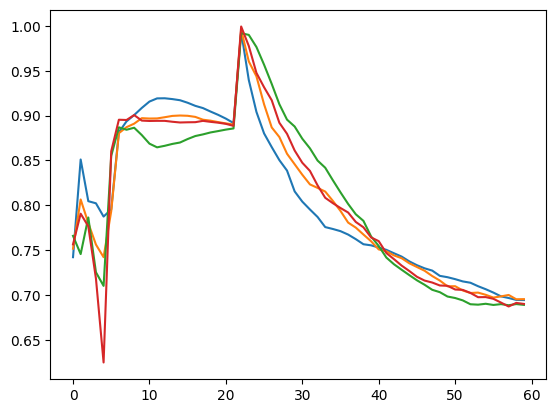

In [173]:
plt.plot(history["controls"])

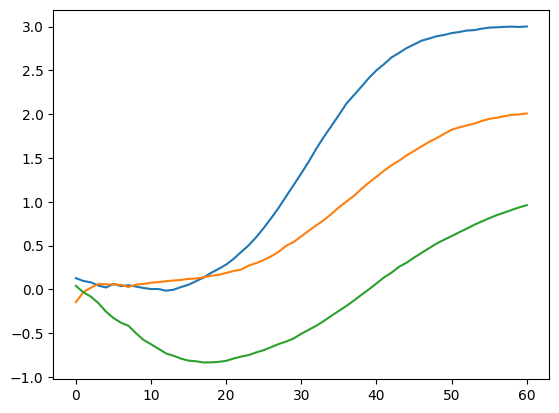

In [167]:
plt.plot(history["positions"])

In [174]:
drone_params = DroneParameters(
   l = 0.232,
   R_radius = 0.15
)

In [181]:
animate_drone_3d_multi(drone_params, history["positions"], [[3,2,1]])


Saving animation to drone_3d_multi.gif...
Animation saved successfully to drone_3d_multi.gif
